**Note on the imported packages.** At some point, we will use Naima here, and if I understand correctly, it requires Numpy v. < 2. But I had Numpy of the version 2...! So you can either downgrade Numpy to <2, or (what my best friend ChatGPT said to do) create an environment with Numpy < 2 and Naima installed (and some other packages which do not seem to be in conflict with Numpy or Naima). If you follow the second way, ensure that this Notebook is launched from the right environment. 

But if you just want to use IBSEn for Orbit / Winds & Stars / IBS / electron evolution and NOT for specta / light curves, you're good to go without Naima.


In [55]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
import ibsen


First, initialize the system you want to work with. I use the cartesian coordinate system with the origin in the optical star, the x-axis is directed to the periastron of the pulsar orbit, z-axis is directed as the angular velocity of the pulsar $\mathbf{\Omega}_{puls}$, y-axis is perpendicular to $x$ and $y$ directed so that $\mathbf{e}_x \times \mathbf{e}_y = \mathbf{e}_z$.

![coords](../../Pictures/fig_orbit_coords.jpg)

For this, create a class ``orb:Orbit`` that would be passed as an argument in future to everything else. Once it is created, you can obtain some orbit parameters (orbital periond, eccentricity, etc.) or the arrays of coordinates (x, y, r, ...) along the orbit.


The simplest way to do it is like this:

The psrb orbit parameters are
T [days] =  1236.724526
e =  0.874
nu_los [rad] =  2.3
a [au] =  6.610410398825172
b [au] =  3.212169756477842
r_per [au] =  0.8329117102519716
r_apo [au] =  12.387909087398373
r at t = 250 days [AU] =  138876731386097.75
true anomaly at t = 250 days =  2.828127182902617
new T [days] =  800.0
my T [days] =  1500.0


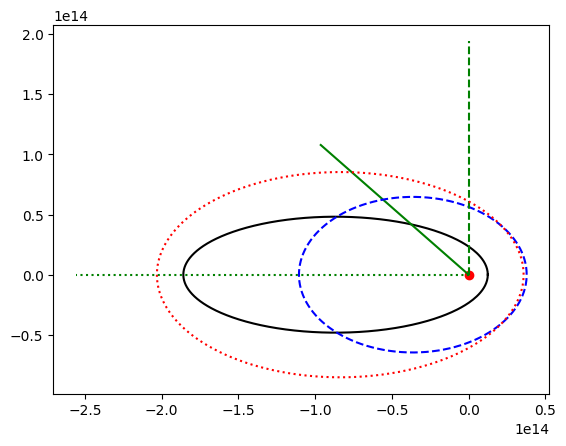

In [2]:
from ibsen.orbit import Orbit

DAY = 86400.
AU = 1.5e13

"""
This is the simplest way of initializing an orbit: by a keyword sys_name = ...
The only available options are
(1) 'psrb' (PSR B1259-63), or
(2) 'rb' and (3) 'bw' for typical values for redback and black widow spider pulsar systems.

n is the number of points on the orbit to tabulate, 1000 is default
"""

sys_name = 'psrb' 
orb = Orbit(sys_name = sys_name, n=1003)

print(f'The {sys_name} orbit parameters are')
print('T [days] = ', orb.T / DAY) # orbital period
print('e = ', orb.e) # eccentricity
print('nu_los [rad] = ', orb.nu_los) # the angle between the star-to-periastron direction and the direction to the observer
print('a [au] = ', orb.a / AU) # major half-axis of the orbit
print('b [au] = ', orb.b / AU) # minor half-axis of the orbit
print('r_per [au] = ', orb.r_periastr / AU) # periastron orbital separation
print('r_apo [au] = ', orb.r_apoastr / AU) # apoastron orbital separation
print('r at t = 250 days [AU] = ', orb.r(t = 250 * DAY)) # the S-P distance at t = 250 days after peiastron passage
print('true anomaly at t = 250 days = ', orb.true_an(t = 250 * DAY)) # the true anomaly at t = 250 days after peiastron passage



plt.plot(orb.xtab, orb.ytab, color='k') # plot the orbit
plt.scatter(x=0, y=0, color='r') # place an optical star in the center of coordinates
plt.plot([0, 3 * orb.b * cos(orb.nu_los)],
         [0, 3 * orb.b * sin(orb.nu_los)],
         color='g', ls='-') # plot a line from the optical star to the direction of an observer

"""
You can pass period, e, tot_mass, and nu_los as arguments, and these 
explicit parameters overwrite the default ones:
"""

orb_new = Orbit(sys_name = sys_name, period = 800. * DAY, e = 0.49, nu_los=pi/2.)

print('new T [days] = ', orb_new.T / DAY) # new orbital period


plt.plot(orb_new.xtab, orb_new.ytab, color='b', ls = '--') # plot the new orbit
plt.plot([0, 3 * orb_new.b * cos(orb_new.nu_los)],
         [0, 3 * orb_new.b * sin(orb_new.nu_los)],
         color='g', ls='--')

"""
Or you can pass sys_name = some dictionary that should contain the following values
[honestly, for the orbit we need only period, total mass and eccentricity. Everything
else will be needed later, but currently it is assumed that you pass all parameters
already at the stage of initializing the orbit.]
"""

orb_my_dict = {
             'e': 0.7, # eccentriciry. Necessary for orbit
             'M': 30. * 2e33, # total mass m1 + m2 [g]. The code does NOT check that M = Mopt + M_ns. Necessary for orbit
             'D': 3e3 * 3e18, # the distance to the system [cm]. Necessary for spectrum (later)
             'Ropt': 12 * 7e10, # the optical star radius [cm]. Necessary for winds (later)
             'T': 1500 * DAY, # the orbital period [s]. Necessary for orbit
             'Topt': 3.4e3, # the optical star effective temperature [K]. Necessary for winds (later)
             'Mopt': 28.6 * 2e33, # the optical star mass [g]. Necessary for winds (later)
             'M_ns': 1.4 * 2e33, # the neutron star mass [g]. Not necessary, can be skipped
             'nu_los': pi # the angle between the star-to-periastron direction
                          # and the direction to the observer (= 3pi/2 - \omega) [rad]
                          # technically, necessary for orbit, but in reality only used later
           }

orb_my = Orbit(sys_name = orb_my_dict) # again, if you explicitly set something as an argument here,
                                               # it overrites the value from the dictionary

print('my T [days] = ', orb_my.T / DAY) 


plt.plot(orb_my.xtab, orb_my.ytab, color='r', ls = ':')
plt.plot([0, 3 * orb_my.b * cos(orb_my.nu_los)],
         [0, 3 * orb_my.b * sin(orb_my.nu_los)],
         color='g', ls=':') # plot a line from the optical star to the direction of an observer

Now, let us initialize the winds with the class ``winds:Winds``. Quick remark: Apart from outflows-related stuff, I temporarily put everything related to the properties of an NS (P, meaning ''pulsar'') and an optical star (S, meaning ''Star'') in this class: so temperature/radius of S, magnetic fields as functions of r (**TODO**) --- are all initialized/calculated here.  

Anyway, to the optflows. For the pulsar relativistic wind pressure, I use this dimentionless expression:
$$P_p = f_p \left(\frac{R_\mathrm{opt}}{r_\mathrm{from~P}}\right)^2.$$
$f_p=0.1$ is default.

The optical star has two types of them: the polar spherically-symmetrical wind and the axially-symmetrical thin outflow, a decretion disk. Their pressures are introduced in a dimensionless fashion:
$$P_w = \left(\frac{R_\mathrm{opt}}{r_\mathrm{from~S}}\right)^2, $$
$$P_d = f_d \left(\frac{R_\mathrm{opt}}{\rho}\right)^{n_P} \exp{\left(-\frac{1}{2}\left(\frac{r_{\perp}}{H(\rho)}\right)^2\right)} $$
The default values are: $f_d=10, n_P=3$.

Here I use the following notation. If $r$ is the distance from S to a given point in space, then $\rho$ is its projection onto the disk, and $r_\perp$ is the perpendicular from the disk to this point. $n_P$ is a disk radial exponent. You can also specify the alternative ''radial'' dependence in form of a broken power law (the norm is chosen so that it it continious in $\rho=r_\mathrm{trunk}$):
\begin{equation}
\begin{cases}
\propto \rho^{-n_P}, & \rho < r_\mathrm{trunk}\\
\propto \rho^{-2},  & \rho >= r_\mathrm{trunk}.
\end{cases}
\end{equation}

The ''vertical'' part is, as you can see, a Gaussian with the width of the height of the disk. This height is defined as
$$H(r)/r = \delta \left(\frac{\rho}{R_\mathrm{opt}}\right)^{\mathrm{height\_exp}}$$
The default values are: $\delta=0.01, \mathrm{height\_exp}=0.5.$

To calculate the $\rho$ and $r_\perp$ you have to know the orientation of the disk in space relative to the pulsar orbit. I define the disk plane by its normal vector $\mathbf{n}_{\rm disk}$ which I obtain by rotating the normal to the pulsar plane $\mathbf{n}_{\rm orb} = (0, 0, 1)^T$. First, (1) incline it at the angle $i$ to the direction of periastron and then (2) rotate it around the normal $\mathbf{n}_{\rm orb}$  at the angle $\alpha$. The default values are $i=30^\circ, \alpha = 0^\circ$.

Here you can also calculate the distance at which $P_w + P_d = P_p$ and calculate the effective relation between winds momenta at the moment of time after the periastron passage $t$.

Currently, all information about the stars is stored in ``winds:Winds``. In this class, there are their magnetic fields and functions for calculating them at some distance and at the shock apex (at time $t$) and the same for the photon field of the optical star. In future maybe it worth making two classes: ``pulsar`` (which would contain everything about the outflows and magn fields of the pulsar)  and ``opt_star`` (same for the optical star) and then we can omit the class ``winds`` at all, as ``ibs`` (see further) could accept ``pulsar`` and ``opt_star`` as arguments, calculating the position of $r_{\rm apex}$.


disk equator passage times [days]:
-12.861370702230639 20.93134755958645
r_se / r_sp (10 days)
0.7597516210163318
beta_eff (10 days, 20 days, 40 days)
0.09999485647340112
0.017512718451292503
0.09344767089308863


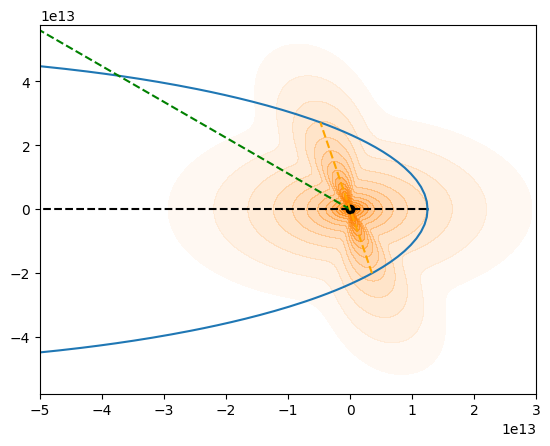

In [3]:
from ibsen.winds import Winds

# having initialized orb:Orbit, initialize winds:Winds

winds = Winds(orbit=orb, sys_name = sys_name, alpha=-10/180*pi, incl=23*pi/180,
              f_d=165, f_p=0.1, delta=0.02, np_disk=3, rad_prof='pl', r_trunk=None,
             height_exp=0.25)
to_show = 'near_per'

### let's tabulate the pressures of polar + decret. disk pressure

if to_show == 'whole':
    x_forp = np.linspace(-orb.a*2, orb.a*2, 301)
    y_forp = np.linspace(-orb.b*2, orb.b*2, 305)
if to_show == 'near_per':
    x_forp = np.linspace(-5.13e13, 6.1e13, 301)
    y_forp = np.linspace(-8.5e13, 9.4e13, 305)
    
XX, YY = np.meshgrid(x_forp, y_forp, indexing='ij')
disk_ps = np.zeros((x_forp.size, y_forp.size))
for ix in range(x_forp.size):
    for iy in range(y_forp.size):
        vec_from_s_ = np.array([x_forp[ix], y_forp[iy], 0])
        r_ = (x_forp[ix]**2 + y_forp[iy]**2)**0.5
        disk_ps[ix, iy] = (winds.decr_disk_pressure(vec_from_s_) 
                           +
                           winds.polar_wind_pressure(r_)
                           )
disk_ps = np.log10(disk_ps)

P_norm = (disk_ps - np.min(disk_ps)) / (np.max(disk_ps) - np.min(disk_ps))

from matplotlib.colors import ListedColormap, Normalize

########### some magic for displaying the winds, never mind ################
orange_rgba = np.array([1.0, 0.5, 0.0, 1.0]) 
n_levels = 20
colors = np.tile(orange_rgba[:3], (n_levels, 1))  
alphas = np.linspace(0, 1, n_levels)           
colors = np.column_stack((colors, alphas))     
custom_cmap = ListedColormap(colors)
disk_ps[disk_ps < np.max(disk_ps)-4.5] = np.nan
norm = Normalize(vmin=np.min(disk_ps), vmax=np.max(disk_ps))
############################################################################

t1, t2 = winds.times_of_disk_passage
print('disk equator passage times [days]:')
print(t1/DAY, t2/DAY)
vec_disk1, vec_disk2 = winds.vectors_of_disk_passage

orb_x, orb_y = orb.xtab, orb.ytab
################### ------ drawing the orbit again ------- ################
plt.plot(orb_x, orb_y)                                                    #
plt.contourf(XX, YY, disk_ps, levels=n_levels, cmap=custom_cmap)          #
plt.scatter(0, 0, c='k')                                                  #
plt.plot([np.min(orb_x), np.max(orb_x)], [0, 0], color='k', ls='--')      #
plt.plot([0, 3*orb.r_apoastr*cos(orb.nu_los)],                            #
         [0, 3*orb.r_apoastr*sin(orb.nu_los)], color='g', ls='--')        #
xx1, yy1, zz1 = vec_disk1                                                 #
xx2, yy2, zz2 = vec_disk2                                                 #
plt.plot([xx1, xx2], [yy1, yy2], color='orange', ls='--')                 #
                                                                          #
if to_show=='whole':                                                      #
    plt.xlim(-orb.a*2, orb.a*2)                                           #
    plt.ylim(-orb.b*2, orb.b*2)                                           #
                                                                          #
if to_show == 'near_per':                                                 #
    plt.xlim(-0.5e14, 0.3e14)                                             #
    plt.ylim(-orb.b*1.2, orb.b*1.2)                                       #
############################################################################
print('r_se / r_sp (10 days)')
print(winds.dist_se_1d(t = 10 * DAY) / orb.r(t = 10 * DAY)) # the disnace S-to-E (the point where the pressures of opt. star
                                                            # outflows are equal to the pulsar pressure) at 10 days (in units of r_sp)
print('beta_eff (10 days, 20 days, 40 days)')
print(winds.beta_eff(t = 10 * DAY)) # effective beta at t=10 days, it's close to f_p, as we are mostly in the polar wind
print(winds.beta_eff(t = 20 * DAY)) # effective beta at t=20 days, it's << f_p, as we are in the disk
print(winds.beta_eff(t = 40 * DAY)) # effective beta at t=40 days, again is close to f_p, as we are have already left the disk

Now it's time for the intrabinary shock (ibs) from class IBS. I use the model from Canto, Raga, and Wilkin

https://ui.adsabs.harvard.edu/abs/1996ApJ...469..729C/abstract

in which (if coordinates are in units of birary separation) the shock shape depends only on one parameter $\beta$, the relation between the pulsar and the optical star _spherical_ winds momenta. 

![ibs](../../Pictures/IBS.jpg)


To initialize the IBS, you need ``beta`` (float) and ``s_max`` which defines where the shock ends. ``s_max`` should be either a float ($\leq 5$, then it is treated as maximum arclength in dimensionless units) or a string ''bow'' (then only such part of the IBS left that $\theta \leq 90^\circ$), or a string ''incl'' (then only such part of the IBS left that the angle between the tangent and the direction to the pulsar is $\leq 90^\circ + 10^\circ$).

You can either just pass $\beta=...$ as an argument and obtain the shock coordinates (x, y, r, ...) or you can pass winds:Winds class as an argument together with ``t_forbeta`` to calculate the effective $\beta_\mathrm{eff}$ at time $t_\mathrm{for~beta}$ after periastron passage. You can also rotate the shock or recalculate its properties to the moment ``t_forbeta``. Upon initializing, the class obtains the values x, y, s (arclength from apex to the given point), r, theta, r1, theta1, tangent (the angle between the tangent to a given point and the x-axis), thetainf (the max angle theta), and x_apex (the distance from the pulsar to the IBS apex).

One of the properties of an ibs is the bulk motion of matter along the shock. From ibs:IBS you can retrieve the $\Gamma(s)_\mathrm{bulk}$ --- well, currently it is fixed to a linear growth with the arclength $s$:
\begin{equation}
    \Gamma(s) = 1 + (\Gamma_\mathrm{max}-1)\frac{s}{s_\mathrm{max~g}}
\end{equation}

and Doppler-factor $\delta(s)$. For this, you need to provide the parameters of this linear function: ``gamma_max`` (default = None) and ``s_max_g`` (default = 4).

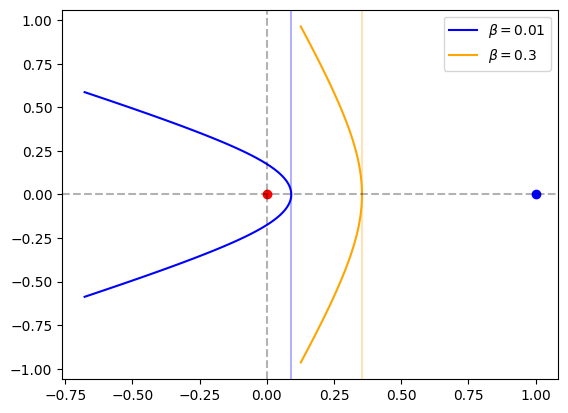

In [4]:
from ibsen.ibs import IBS
# Two very simple dimensonless IBS with given betas

beta1 = 0.01
ibs1 = IBS(beta=beta1, n=51, s_max = 1, one_horn=False) 
plt.plot(ibs1.x, ibs1.y, color='b', label = rf'$\beta = {beta1}$')
plt.axvline(x = ibs1.x_apex, color='b', alpha = 0.3)

beta2 = 0.3
ibs2 = IBS(beta=beta2, n=51, s_max = 1, one_horn=False) 
plt.plot(ibs2.x, ibs2.y, color='orange', label = rf'$\beta = {beta2}$')
plt.axvline(x = ibs2.x_apex, color='orange', alpha = 0.3)


plt.scatter(0, 0, color='r') # pulsar is in (0, 0)
plt.scatter(1, 0, color='b') # star is in (1, 0)
plt.axhline(y=0, color='k', ls='--', alpha = 0.3)
plt.axvline(x=0, color='k', ls='--', alpha = 0.3)
plt.legend()

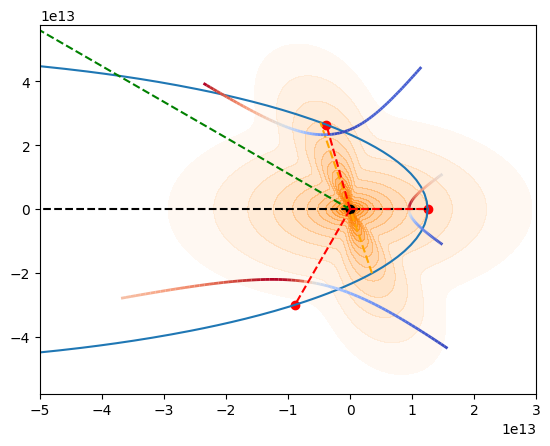

In [5]:
# now let's defnie the IBS with the kinematics of the bulk motion and draw
# several IBSs in several times with color corresponding to the Doppler factor

from matplotlib.collections import LineCollection
########## some helper function for drawing, whatev ############################ 
####################################################################################
####################################################################################
def plot_with_gradient(fig, ax, xdata, ydata, some_param, colorbar=False, lw=2,
                       ls='-', colorbar_label='grad', minimum=None, maximum=None):
    """
    to draw the plot (xdata, ydata) on the axis ax with color along the curve
    marking some_param. The color changes from blue to red as some_param increases.
    You may provide your own min and max values for some_param:
    minimum and maximum, then the color will be scaled according to them.
    """
    # Prepare line segments
    points = np.array([xdata, ydata]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Normalize some_p values to the range [0, 1] for colormap
    vmin_here = minimum if minimum is not None else np.min(some_param)
    vmax_here = maximum if maximum is not None else np.max(some_param)
    
    norm = Normalize(vmin=vmin_here, vmax=vmax_here)
    
    # Create the LineCollection with colormap
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(some_param[:-1])  # color per segment; same length as segments
    lc.set_linewidth(lw)
    
    # Plot

    line = ax.add_collection(lc)
    
    if colorbar:
        fig.colorbar(line, ax=ax, label=colorbar_label)  # optional colorbar
        
    ax.set_xlim(xdata.min(), xdata.max())
    ax.set_ylim(ydata.min(), ydata.max())
####################################################################################
####################################################################################
####################################################################################


#####################################################################################
###### -------------------- drawing orbits and winds ------------------------ #######

fig, ax = plt.subplots()

ax.plot(orb_x, orb_y)
ax.contourf(XX, YY, disk_ps, levels=n_levels, cmap=custom_cmap)
ax.scatter(0, 0, c='k')
ax.plot([np.min(orb_x), np.max(orb_x)], [0, 0], color='k', ls='--')
ax.plot([0, 3*orb.r_apoastr*cos(orb.nu_los)], 
         [0, 3*orb.r_apoastr*sin(orb.nu_los)], color='g', ls='--')
xx1, yy1, zz1 = vec_disk1
xx2, yy2, zz2 = vec_disk2
ax.plot([xx1, xx2], [yy1, yy2], color='orange', ls='--')

#######################################################################################
#######################################################################################
##### For t = 25 days, 0, and 20 days, draw an IBS calculated from the winds initialized
##### before. Draw it with color corresponding to the doppler factor delta.

for t in (-25*DAY, 0*DAY, 20*DAY):
    ibs = IBS(
              beta=None,        # since we also pass winds = ..., we don't need explicit beta
              gamma_max=3.,     # max bulk motion gamma
              s_max=1.,         # where to cut IBS. s_max = 1 means 'cut it where the arclength
                                # along the shock is equal to the 1 orbital separation at a given time'
                                # can also be strings ``bow`` or ``incl``.
        
              s_max_g=4,        # a parameter of a linear function Gamma(s) 
              n=41,             # number of points in ONE horn of IBS to initialize
              one_horn=False,   # whether we want one (upper, theta>0) horn of the IBS
                                # or both horns. If False, then 2 horns will be initialized,
                                # each with n = 41 points.
        
              winds = winds,    # previously initialized class winds:Winds to calculate beta_eff
              t_to_calculate_beta_eff=t  # when to calculate beta_eff
              )
    ibs_real = ibs.rescale_to_position() # rotates the IBS properly and rescales all dimentions to the real ones
    plot_with_gradient(fig=fig, ax=ax,
                       xdata=ibs_real.x, 
                       ydata=ibs_real.y, 
                       some_param=ibs_real.real_dopl # use ibs_real.real_dopl if ibs_real is already an IBS obtained by
                                                     # the ibs.rescale_to_position() method 
                      )
    ax.scatter(orb.x(t), orb.y(t), color='r')
    ax.plot([0, orb.x(t)], [0, orb.y(t)], color='r', ls='--')
if to_show=='whole':                                                      
    ax.set_xlim(-orb.a*2, orb.a*2)                                           
    ax.set_ylim(-orb.b*2, orb.b*2)                                           
                                                                          
if to_show == 'near_per':                                                 
    ax.set_xlim(-0.5e14, 0.3e14)                                             
    ax.set_ylim(-orb.b*1.2, orb.b*1.2)

Now it's time to do something useful. Let's calculate the spectrum of relativistic electrons in each point of IBS that we have just initialized. There are many parameters that you should/may specify for this, so the full list is in the example below right in the Python code, with descriptions and default values. 

Here I will only comment on the parameter ``cooling`` that specifies which model of electrons evolution would you like to use. 

First of all, you can set ``cooling='no'``, and the spectrum of electrons in each $s$ will be (numerically) set to $Q_\mathrm{inj}(s, E)$. Note that from the physical point of view this is nonsense, as $Q$ is the number of $\mathrm{e}^-$ injected per unit of time ($\mathrm{s}^{-1}$), so $Q\times (E/\dot E)$ gives the numer of particles, but setting ``cooling='no'`` ignores the dimentions difference and just sets $n(s, E) = Q(s, E)$.

There are several options of various stationary distributions in each point $s$. ''Stationary'' means that the equation
$$ \frac{\mathrm{d}(n(s, E) \dot E(s, E))}{\mathrm{d}E} = Q_\mathrm{inj}(s, E)$$ 
is being solved analytically in each point of $s$, yielding
$$ n(s, E) = \frac{1}{|\dot E(s,E)|} \int_E^\infty Q(s, \xi) \mathrm{d}\xi. $$ 
Here 
$$\dot E(s, E) = \eta_\mathrm{syn}\dot E_\mathrm{syn} (B(s), E) + \eta_\mathrm{IC}\dot E_\mathrm{IC} (u_\gamma(s), E) - \frac{E}{t_a}$$.

- ``cooling=stat_apex`` calculates the stationary e-spectrum on each $s$ using magnetic and photon fields as in the IBS apex;
- ``cooling=stat_ibs`` calculates the stationary e-spectrum on each $s$ using magnetic and photon fields in this point on IBS;
- ``cooling=stat_mimic`` calculates the stationary e-spectrum on each $s$ with the ''adiabatic time'' $t_a$ calculated to mimic the ''proper'' advection equation solution:
  $$
  t_a = \frac{s_\mathrm{max~g}}{\Gamma_\mathrm{max}-1} \sqrt{\Gamma_\mathrm{bulk}(s)^2-1}.
  $$
- ``cooling=adv`` solves the 2-dimentional advection-over-s + coooling-over-e equation
$$
    v(s) \frac{\partial n}{\partial s} + \frac{\partial (n \dot E(s, E))}{\partial E} = \tilde{Q}_\mathrm{inj}(s, E)
$$
with the same $\dot E$ as before but without ''advection losses''.

**Note.** I was also working on the idea of the equation with "leakage". If we change the term $v \partial / \partial s \rightarrow 1/T_\mathrm{eff}$ (and it can be done accurately), the following equation with leakage is obtained, with s as a parameter:
$$
\frac{\mathrm{d}(n\dot E)}{\mathrm{d}E} + \frac{n}{T_\mathrm{eff}} = Q_\mathrm{inj}
$$
which also has an analytical solution and, anyway, it is ODE and so it seems like it's a good idea to reduce the 2-simentional PDE to a set of (independent, for each $s$) ODE. In reality, though, it turnes out that solvind it we meet some numerical problems and the total time to solve this for each $s$ takes approximately the same time as just solving the transport PDE. So for now I allowed options ``cooling=leak_apex``, ``cooling=leak_ibs``, and ``cooling=leak_mimic``, but I have not tested them, and it seems like some numerical problems sometimes arise there. 

**The class ibs:IBS that you pass to class ``el_ev:ElectronsOnIBS`` should have been initialized not with manual ``beta``, but with the class ``winds:Winds`` (see previous section). This ``ibs:IBS`` class should be with dimentionless coordinates, that is, NOT the one obtaied with ``rescale_to_position()``**.

**Currently you are free to pass any parameters of the magnetic field in the IBS apex from the pulsar and from the optical star, but when recalculating these values to points on IBS, I assume that all the fields are such that**
$$B \propto r^{-1}$$.

**The photon field is calculated with the ``Topt`` that your dictionary of parameter should have contained at the stage of ``orbit:Orbit`` initialization. The photon field if a purely blackbody optical star radiation.**

At the moment of initializing the class, the spectra $n_e(s,E)$ are not calculated yet (as the calculation may take a while but you maybe just want to know how the magnetic field is distributed along the shock and don't care for e-spectrum). To actually calculate $n_e$, you should do  ``els.calculate()``.

eff beta is 0.05443105871290789


/home/alvkuzin/whole_psrb_project/src/ibsen/el_ev.py:172: RuntimeWarning: divide by zero encountered in divide
  inv_Tf = 1 / (Ts * Edots)
/home/alvkuzin/whole_psrb_project/src/ibsen/el_ev.py:178: RuntimeWarning: invalid value encountered in subtract
  inner_int2d = inner_int_spl(eepr) - inner_int_spl(ee)


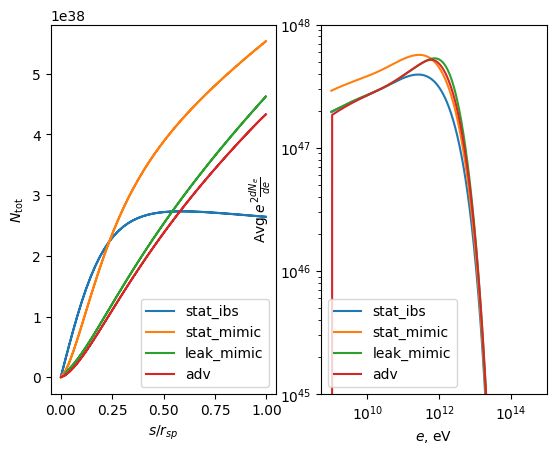

In [6]:
from ibsen.el_ev import ElectronsOnIBS
from scipy.integrate import trapezoid

##### let's again initialize an IBS at, say, 15 days after periastron. Let's do that for three different 
##### models of cooling: stat_ibs, stat_mimic, and adv.
t = 15 * DAY
Nibs = 41
ibs = IBS(beta=None,
          winds=winds,
          gamma_max=3.,
          s_max=1.,
          s_max_g=4.,
          n=Nibs,
          one_horn=False,
           t_to_calculate_beta_eff=t) # the same IBS as before
print('eff beta is', ibs.beta)
r = orb.r(t=t)
rsp = r - winds.dist_se_1d(t)
fig, ax = plt.subplots(nrows=1, ncols=2)

for cooling in ('stat_ibs',
                'stat_mimic',
                'leak_mimic', # can trigger some warnings, not tested!
                'adv'
                ):
    if cooling in ('adv', 'leak_mimic'): eta_a = 1e20 # to dump ``adiabatic losses`` for advection model
    else: eta_a = 1
        
    els = ElectronsOnIBS(
                         Bp_apex=1, # The magnetic field [G] in the Apex of the IBS coming from pulsar. Mandatory.
                         ibs=ibs, # The IBS at which the e-spec should be calculated. Mandatory.
                         cooling=cooling, # How to cool the particles. Default is None.
                         to_inject_e = 'ecpl', # The injection spectrum keyword. Current options: 'ecpl' (default) or 'pl'.
                         to_inject_theta = '3d', # If '2d', then injection distribution over theta is uniform. 
                                                 # If '3d' (default), then \propto sin(theta). 
        
                         ecut = 5.e12,  # Cutoff energy [eV] for ecpl. Default is 1e12.
                         p_e = 1.8, # the injection spectrum index. Default is 2.
                         to_cut_e = True, # If to set injecttion spectrum to 0 outside of the band emin < e < emax. Default is True.
                         emin = 1e9, # If to_cut_e == True, then it is the min e-energy of inj spectrum [eV]. Default is 1e9. 
                         emax = 5e14, # If to_cut_e == True, then it is the max e-energy of inj spectrum [eV]. Default is 5.1e14. 
                         norm_e = 1.e37, # the overall normalization of the injection spectrum. Default is 1e37. 
                                         # if cooling != 'no', then norm_e is treated as total number of injected e- / second.
        
                         Bs_apex=0., # The magnetic field [G] in the Apex of the IBS coming from opt. star. Default is 0.
                         eta_a = eta_a, # t_a = eta_a * dist/c. Can be either a float of None. If None, then the value
                                        # 1e20 is used. It is hardcoded that any value above 1e10 is essentially infinity,
                                        # so if you want no adiabatic losses, pass either eta_a > 1e10 or eta_a = None.
                                        #    Default is None.
        
                         eta_syn = 1., # coef before synchrotron losses term. Default is 1.
                         eta_ic = 1., # coef before IC losses term. Default is 1.
                         to_cut_theta =  False, # If to inject only at theta < where_cut_theta.
                         where_cut_theta = pi/2, # If to_cut_theta == True, then non-zero injection is only at theta < where_cut_theta.
                                                 # Default if pi/2. 
                         ) 
    
    dNe_de_IBS, e_vals = els.calculate(
                                       to_set_onto_ibs=True, # If to remember the calculated e-spec so you can access it as
                                                             # the class attributes later. Default is True.
                                       
                                       to_return=True        # If to return 2d-spectra (on s_grid x e_vals) and e_vals. Default is False.
                                       )
    ### This dNe_de_IBS is a 2d array so that [:, j] is a slice over s at j-th energy, and [i, :] is a slice over e in i-th point of IBS
    ntot = trapezoid(dNe_de_IBS, e_vals, axis=1) # The total number of e at each s of IBS
    dNe_de_IBS_avg = trapezoid(dNe_de_IBS[Nibs+1:2*Nibs-1, :],
                               ibs.s[Nibs+1:2*Nibs-1],
                               axis=0) / np.max(ibs.s) # the e-spectrum averaged over the upper horn of the IBS except the 1st point
    
    
    ### let's plot the n_tot as function of theta...
    #ax[0].plot(ibs.theta / pi * 180, ntot, label  = cooling)
    ax[0].plot(ibs.s, ntot, label  = cooling)
    #ax[0].set_xlabel(r'$\theta$, deg')
    ax[0].set_xlabel(r'$s/r_{sp}$')
    
    ax[0].set_ylabel(r'$N_\mathrm{tot}$')
    ax[0].legend()
    
    ### ... and the average e-spectrum 
    ax[1].plot(e_vals, e_vals**2 * dNe_de_IBS_avg, label = cooling)
    #ax[1].plot(e_vals, e_vals**2 * dNe_de_IBS[20, :], label = cooling)
    
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel(r'$e$, eV')
    ax[1].set_ylabel(r'Avg $e^2\frac{dN_e}{de}$')
    ax[1].legend()
    ax[1].set_ylim(1e45, 1e48)


Now it's close to finish: let's calculate the spectrum of the IBS. We know its shape, we know everything about electrons emitting, so we can calculate the Synchrotron and inverse Compton emission. This is done using \texttt{Naima} code, so you should have it installed. As before, the description of all the needed parameters is given right in the Python code, but I want to comment on how the logic of the calcultion works.
- We get all parameters like magnetic and photon fields in apex and then recalculate them to every point of the IBS
- You also know the electrons spectrum $n_e(s, E)$ in the lab frame.
- If you want to: ``lorenrz_boost=True``, you can recalculate everything to the co-moving systems of frame $B\rightarrow B' = B\sqrt{\frac{2\Gamma^2+1}{3}}$, $u \rightarrow u' = u\Gamma^2 \frac{3+\beta^2}{3}$, \begin{equation}
        n(E) \rightarrow n'(E') = \frac{1}{2}\int_{-1}^1 \frac{n(E'\Gamma(1+\beta\mu'))}{\Gamma(1+\beta\mu')} d\mu'.
    \end{equation}
- Then, using either primed or not primed values, Sy+IC spectrum may be calcuated. For each $s$, \texttt{Naima} gives the SED $E'F'(E')$. It gets Doppler-boosted to the lab frame: $EF(E) = \delta^\mathrm{3~or~4} E'F'(E')\Bigg|_{E'=E/\delta}$. I am not sure what the power (3 or 4) should be of the Doppler factor $\delta = 1/(\Gamma(1-\beta \mu))$. Let's denote this power $p_\delta$. But anyay, the total spectrum is then summarized over the whole IBS:
\begin{equation}
        E F(E) = \frac{\int  (E'F'(E', s))^{\rm Naima} \times \delta_\mathrm{doppl}(s)^{p_\delta} ~ds}{\int ds} \Bigg|_{\nu' = \nu/\delta(s)}
\end{equation}

If you want to calculate the spectrum quicker, you can set ``simple=True`` to do it simpler (but slightly incorrectly). Then the \texttt{Naima} will calculate the SED only in the apex, and this SED then will be rescaled to each point of the IBS by $\mathrm{SED}_\mathrm{Sy}(s) = \mathrm{SED}_\mathrm{Sy}(0) \times (B(s)/B(0))^2$, $\mathrm{SED}_\mathrm{IC}(s) = \mathrm{SED}_\mathrm{Sy}(0) \times u_\gamma(s)/u_\gamma(0)$. After that, the total spectrum will be doppler-boosted as before.


1.4431300275265406
Swift 0.3-10 keV flux is 9.801299342857744e-13
H.E.S.S. 0.4-100 TeV flux is 1.6951696466794096e-12
(500,)
(500,)


Text(0.5, 0, '$\\theta$, deg')

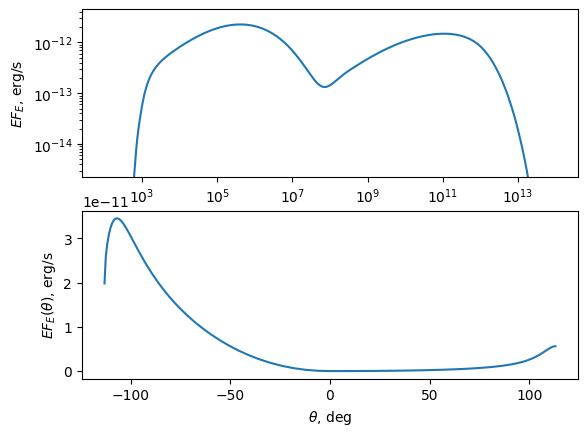

In [7]:
from ibsen.spec import SpectrumIBS
from scipy.optimize import curve_fit

def powerlaw(E, g, norm):
    return norm * E**(-g)

spec = SpectrumIBS(els=els, # els:ElectronsOnIBS class. Mandatory
                   simple=True, # Whether to calculate the spectrum in a simple fashion (see above). Default is False.
                   syn_only=False, # Whether to calculate only Sy emission. Default it False.
                   delta_power=3, # The power p_delta (see above). Default is 4.
                   lorentz_boost=True, # Whether to perform Lorentz boost B, u_g, and n(s, E). Default is True.
                                       # If simple=True was set, the e-spectrum
                                       # n(s, E) will not be transformed, but the s-averaged spectrum (in lab frame) will be used instead. 
                   
                   abs_photoel=True, # Whether to include the TBabs-like photoelectric absorbtion. Default is True.
                   nh_tbabs=0.8, # If abs_photoel=True, this is the N_H (in units of 10^22) to use. Default is 0.8. 
                   abs_gg=False, # Whether to include the gamma-gamma absorbtion. Experimental feature, only for PSR B1259-63,
                                 # since it uses the tabulated values.
                   
                   distance = None # The distance to the system [cm]. Default is None. It will try to get the distance from the 
                                   # parameters that you provided for orbit:Orbit, but distance=<some_float> overwrites it.
                  )


E_ = np.logspace(2, 14, 500) 
(e_ph_here, # the grid of photon energies. It should be = E_, but I'm not sure hahhaaaa
 sed_here, # the total SED from IBS: 1-d array of length len(e_ph_here)
 sed_s_here # the SED from each point on IBS. 2-d array of shape (len(ibs.s), len(e_ph_here))
) = spec.calculate_sed_on_ibs(to_return=True, # If to return SED. Default is False
                                     to_set_onto_ibs=True, # If to remember the calculated spec, so you can access it as
                                                             # the class attributes later. Default is True.
                                     
                                     E = E_ # On which energies to calculate the spectrum. Default is np.logspace(2, 14, 1000).
                                     )


#### Calculate the index of the spectrum in Swift energy range. 
#### To avoid effects of absorbtion, perform fitting over (3, 10) keV.
G_ind_swift = spec.index(e1 = 3e3, e2 = 1e4)
print(G_ind_swift)
###########################################################
emissiv_s = trapezoid(spec.sed_s/e_ph_here, e_ph_here, axis=1) # The total flux from the point on IBS

########### Calculate fluxes in keV and TeV ranges.
fl_swift, fl_hess = spec.fluxes( bands = (
                                          [3e2, 1e4],
                                          [4e11, 1e14]
                                         )
                               )
print('Swift 0.3-10 keV flux is', fl_swift)
print('H.E.S.S. 0.4-100 TeV flux is', fl_hess)

fix, ax = plt.subplots(nrows = 2, ncols = 1)
print(spec.e_ph.shape)
print(sed_here.shape)
ax[0].plot(spec.e_ph, sed_here)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(np.max(sed_here)/1e3, np.max(sed_here)*2)
ax[0].set_ylabel(r'$EF_E$, erg/s')
ax[0].set_xlabel(r'$E$, eV')


ax[1].plot(spec.els.ibs.theta*180/np.pi, emissiv_s)
ax[1].set_ylabel(r'$EF_E(\theta)$, erg/s')
ax[1].set_xlabel(r'$\theta$, deg')



I imagine you can be bored with initializing all these classes. If you just want one function to calculate the light curve, even if for just one moment of time, here is the function for that. What it does it:
 - initializes ``orbit:Orbit`` and ``winds:Winds`` classes 
 - for every moment of time, initializes ``ibs:IBS``, ``els:ElectronsOnIBS``, and ``spec:SpectrumIBS`` classes (and calculates everything)
 - stores everything.

**TODO** I have to write the interpolator for getting the approximate values of everything in any moment of time.

In [42]:
from ibsen.lc import LightCurve
t1 = np.linspace(-650, -40, 70) * DAY
t2 = np.linspace(-30, 90, 70) * DAY
t3 = np.linspace(100, 650, 70) * DAY
ts = np.concatenate((t1, t2, t3))
lc = LightCurve(sys_name = 'psrb',
                n_ibs = 13,
                p_e = 1.7,
                times = ts,
                bands = ([3e2, 1e4], [4e11, 1e14]),
                bands_ind = ([3e3, 1e4],),
                full_spec = False,
                to_parall = True, 
                f_d = 500,
                syn_only = False,
                simple = True,
               alpha_deg = -8.,
                s_max = 'bow',
                gamma_max=1.4,
                delta=0.02,
                cooling='stat_mimic',
                ns_field_surf=0.1,
                abs_gg=True
               )
import time
start = time.time()
lc.calculate()
print(f'LC done in {time.time() - start}')


LC done in 4.092152833938599


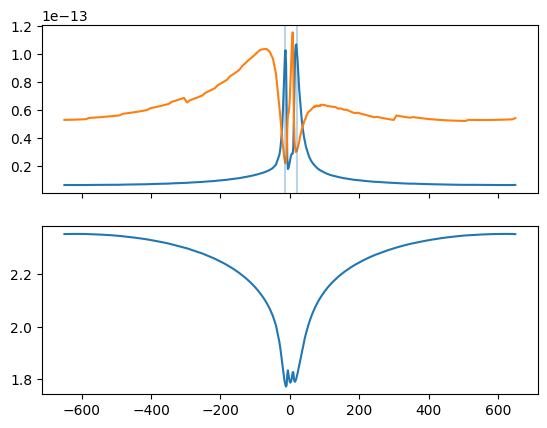

In [43]:
fig, ax = plt.subplots(nrows=2, sharex=True)


fluxes = lc.fluxes
fl_sw, fl_hess = fluxes[:, 0], fluxes[:, 1]
#fl_sw = lc.fluxes
ax[0].plot(ts/DAY, fl_sw)
ax[0].plot(ts/DAY, fl_hess)

#plt.plot(ts/DAY, lc.r_pes / lc.r_sps)
tdisk1, tdisk2 = lc.winds.times_of_disk_passage
ax[0].axvline(x=tdisk1/DAY, alpha=0.3)
ax[0].axvline(x=tdisk2/DAY, alpha=0.3)
ax[1].plot(ts/DAY, lc.indexes)
#plt.plot(ts/DAY, fl_hess)
#plt.yscale('log')

LC done in 10.861047744750977
LC done in 11.128174304962158
LC done in 10.40871262550354
LC done in 11.915501356124878


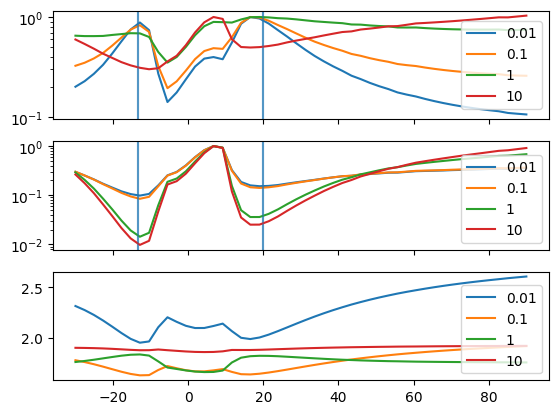

In [54]:
from ibsen.lc import LightCurve

fig, ax = plt.subplots(nrows=3, sharex=True)

t1 = np.linspace(-300, -40, 70) * DAY
t2 = np.linspace(-30, 90, 50) * DAY
t3 = np.linspace(100, 300, 70) * DAY
#ts = np.concatenate((t1, t2, t3))
ts=t2
#for cooling in ('stat_mimic', 'adv'):
for field in (0.01, 0.1, 1, 10):
    
    lc = LightCurve(sys_name = 'psrb',
                    n_ibs = 13,
                    p_e = 1.7,
                    times = ts,
                    bands = ([3e2, 1e4], [4e11, 1e14]),
                    bands_ind = ([3e3, 1e4],),
                    full_spec = False,
                    to_parall = True, 
                    f_d = 500,
                    syn_only = False,
                    simple = True,
                    alpha_deg = -8.,
                    s_max = 'bow',
                    gamma_max=2,
                    delta=0.02,
                    cooling='adv',
                    eta_a = 1e20,
                    ns_field_surf=field,
                    abs_gg=True
                   )
    start = time.time()
    lc.calculate()
    print(f'LC done in {time.time() - start}')
    fluxes = lc.fluxes
    fl_sw, fl_hess = fluxes[:, 0], fluxes[:, 1]
    #fl_sw = lc.fluxes
    cond = np.logical_and(ts>-30*DAY, ts<50*DAY)
    ax[0].plot(ts/DAY, fl_sw/np.max(fl_sw[cond]), label = field)
    ax[1].plot(ts/DAY, fl_hess/np.max(fl_hess[cond]), label = field)
    
    #plt.plot(ts/DAY, lc.r_pes / lc.r_sps)
    tdisk1, tdisk2 = lc.winds.times_of_disk_passage
    for i_ in (0, 1):
        ax[i_].axvline(x=tdisk1/DAY, alpha=0.3)
        ax[i_].axvline(x=tdisk2/DAY, alpha=0.3)
        ax[i_].set_yscale('log')
    
    ax[2].plot(ts/DAY, lc.indexes, label = field)
ax[0].legend()
ax[1].legend()
ax[2].legend()

